This script is designed to ingest csv data from the NYT covid data on GitHUb, and arrange it for analysis

Currently, this script only works on all states and counties in the mainland USA.

The driving idea here was to graph a rolling two week sum of new cases, the maximum period where someone with CoV19 could be contagious.
From there, that sum is converted to a percentage of the region's population.

First, each region's stats are presented alone, first over the roughly three-year period, then with each year layered on top of each other.

Second, The region's stats are compared, first by raw data, then by percentage.  This is where percentage is most important, because it 
offers comparison between regions with varying population sizes.

I found the results very interesting; while population vary wildly from region to region, averages and sums of active cases follow the same shape as the national average.  The numer of cases from region to region is interesting to compare as well. For instance, Kanawha county, with a population of under 200,000, has the steepest rate of case increase. Alameda County, in the SF Bay area, has a much shallower increase.  

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
from datetime import datetime
from random import randrange
import os
import seaborn as sns
import urllib
from bs4 import BeautifulSoup

In [3]:
#links
US_population_data_20_21 = 'https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv'
NYT__us_csv = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
NYT_states_csv = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

# functions

# These two functions pull the data from the nyt GitHub site

def get_filename(link): # pulls file name from url
    split_list = link.split(sep='/')
    return split_list[len(split_list) -1]

def download_from_link(url): # requests and writes file to disk, returns df
    filename = get_filename(url)
    print(filename)
    filepath = f'{os.getcwd()}/covidCSV/{filename}'
    web_request = requests.get(url, allow_redirects=True)
    with open(filepath,'wb') as file:
         file.write(web_request.content)
    file_to_df = pd.read_csv(filepath, encoding='latin-1')
    return file_to_df

def pd_search_tool(df, column,term): # just an attempt to simplify searches
    search = df.index[df[column] == term]
    return search[0]
    # need a way change operator, maybe with if statements


In [4]:
# create folder in current path
!mkdir -p covidCSV
# get census data from csv
census_data = download_from_link(US_population_data_20_21)

change_NYC = census_data[census_data.CTYNAME == 'New York County'].index
census_data.at[change_NYC[0], 'CTYNAME'] = 'New York City County'

pop_data = pd.DataFrame(census_data.loc[0:, census_data.columns[5:10]]).rename(columns={'CTYNAME':'county',
                                                                                'STNAME':'state', 
                                                                                'ESTIMATESBASE2020':'base20', 
                                                                                'POPESTIMATE2020':'pop_est20', 
                                                                                'POPESTIMATE2021':'pop_est21'})

# get files for US and State DFs
USdf = download_from_link(NYT__us_csv)
statedf = download_from_link(NYT_states_csv)

# download all 4 csv files and append to DF
all_counties_df = pd.DataFrame(columns=['date', 'county', 'state', 'fips', 'cases', 'deaths'])
for file_year in range(2020, 2024):
    counties = f'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties-{file_year}.csv'
    #all_counties_df = all_counties_df.append(download_from_link(counties),ignore_index=True )
    all_counties_df = pd.concat([all_counties_df,download_from_link(counties)], ignore_index=True)



co-est2021-alldata.csv
us.csv
us-states.csv
us-counties-2020.csv
us-counties-2021.csv
us-counties-2022.csv
us-counties-2023.csv


In [5]:
# Usdf2 = pd.DataFrame(USdf).copy()
# statedf2 = pd.DataFrame(statedf).copy()
# all_counties_df2 = pd.DataFrame(all_counties_df).copy()

In [6]:
USdf['date'] = pd.to_datetime(USdf['date'])
statedf['date'] = pd.to_datetime(statedf['date'])
all_counties_df['date'] = pd.to_datetime(all_counties_df['date'])
all_counties_df['cases'] = pd.to_numeric(all_counties_df['cases'])

In [7]:
statefips = statedf.fips.unique()
statename = statedf.state.unique()
statefips = {statename[i]:statefips[i] for i in range(len(statefips))}


In [8]:
statefips = pd.DataFrame.from_dict(statefips)
statefips.sort_values(by=0)
statefips = statefips.rename(columns={'index':'state', 0:'fips'})

ValueError: If using all scalar values, you must pass an index

In [9]:
# countyfips = pd.Series(all_counties_df2.fips.unique(), name='fips')
# countynames = pd.Series(all_counties_df2.county.unique(), name='county')
# countyfips = pd.concat([countynames, countyfips], axis=1,)
# countyfips.rename(columns={0:'county', 1:'fips'})
countyfips = all_counties_df.fips.unique()
countyname = all_counties_df.county.unique()
print(len(countyfips), len(countyname))
# countyfips = {countyname[i]:countyfips[i] for i in range(len(countyname))}
# countyfips = pd.DataFrame.from_dict(countyfips,orient='index')
# countyfips.rename(columns={'index':'state', 0:'fips'})
# countyfips



3221 1932


In [10]:
# print(countyfips.query('fips == 20153'),
#       countyfips.query('county == "Rawlins"'))

In [11]:
# print(USdf.info() == Usdf2.info(),
#       statedf.info() == statedf2.info(),
#       all_counties_df.info() == all_counties_df2.info())

# all_counties_df2.isnull().sum()
# all_counties_df2.loc[all_counties_df2.fips.isnull()].sort_values(by=['state', 'county'])


In [12]:
def transform_data(country='USA', state=None,county=None, yearfig=None):

    # poulation = query_pop(country='USA', state='California', county='Orange County', yearfig='EST20')
    population_data = pd.DataFrame(census_data.loc[0:, census_data.columns[5:10]])
    column_list = ['STNAME','ESTIMATESBASE2020','POPESTIMATE2020','POPESTIMATE2021']
        
        #sets index for list "Columns" to be queried
    if yearfig == None:
        x = 2
    elif yearfig == 'BASE20':
        x=1
    elif yearfig == 'EST20':
        x=2
    elif yearfig == 'EST21':
        x=3

    y = x + 1

    if state==None and county==None: 
        population = population_data.loc[population_data['STNAME']==population_data['CTYNAME']].drop_duplicates().sum()[x:y]
        new_df = USdf.copy()
    elif county==None:
        population = population_data.loc[(population_data['STNAME']==population_data['CTYNAME']) & (population_data['STNAME']==f'{state}'), column_list[x:y]]
        new_df = statedf.loc[(statedf['state'] == state)].copy()
    else: 
        population =  population_data.loc[(population_data['STNAME']==f'{state}') & (population_data['CTYNAME']==f'{county} County'), population_data.columns[x:y]]
        new_df = all_counties_df.loc[(all_counties_df['state'] == state)& (all_counties_df['county'] == county)].copy()

    #new_df['date'] = pd.to_datetime(new_df['date'])  # HERE!!!!!
    print(new_df.columns)

    daily_diff = new_df['cases'].diff()
    day7avg = daily_diff.rolling(7).sum() / 7
    twoWeekSum = daily_diff.rolling(14).sum()
    sum_2_pop = (twoWeekSum / int(population.iloc[0])) * 100
    total_2_pop = (new_df['cases'] / int(population.iloc[0])) * 100

    dfshape = {'date':new_df['date'],'new_cases':daily_diff,'7_day_average':day7avg,'2_week_sum':twoWeekSum,'2_week_sum_over_population':sum_2_pop, 'case_totals_over_population':total_2_pop}
    # return pd.DataFrame(dfshape)
    newer_df = pd.DataFrame(dfshape)
    return new_df.merge(newer_df, how='left',on='date')





In [13]:
# visualize data
# this should maybe be a class?

# graph data over full 3 year period
def graph_over_time(df, column):

    # separate search data by year
    end_of_20 = pd_search_tool(df, 'date', '2021-01-01')
    end_of_21 = pd_search_tool(df, 'date', '2022-01-01')
    end_of_22 = pd_search_tool(df, 'date', '2023-01-01')
    
    # visualize
    f = plt.figure()
    f.set_figwidth(20)

    # x axis = dates, y axis = selected column
    plt.plot(df.date[0:end_of_20],df[f'{column}'][0:end_of_20], color='blue', label='2020')
    #plt.plot(df.date, color='blue', label='2020')

    plt.plot(df.date[end_of_20:end_of_21],df[f'{column}'][end_of_20:end_of_21], color='purple', label='2021')
    plt.plot(df.date[end_of_21:end_of_22],df[f'{column}'][end_of_21:end_of_22], color='red', label='2022')
    plt.plot(df.date[end_of_22:],df[f'{column}'][end_of_22:], color='orange', label='2023')
    plt.legend(loc='upper left')
    plt.ylabel(f'{column}')
    plt.title(label=f'{column} over all time')

    plt.show

def graph_year_overlap(df,column):
     
     # separate data by year
    end_of_20 = pd_search_tool(df, 'date', '2021-01-01')
    end_of_21 = pd_search_tool(df, 'date', '2022-01-01')
    end_of_22 = pd_search_tool(df, 'date', '2023-01-01')

    # reset indexes so the year overlay
    df2020 = pd.DataFrame(df[f'{column}'][0:end_of_20]).set_index(pd.Index(range(0, end_of_20)))
    df2021 = pd.DataFrame(df[f'{column}'][end_of_20:end_of_21]).set_index(pd.Index(range(0, (end_of_21 - end_of_20))))
    df2022 = pd.DataFrame(df[f'{column}'][end_of_21:end_of_22]).set_index(pd.Index(range(0, (end_of_22-end_of_21))))
    df2023 = pd.DataFrame(df[f'{column}'][end_of_22:]).set_index(pd.Index(range(0, ((df.count()[0])-end_of_22))))

    # create NaNs for dates prior to first US case in 2020
    dummy_row = pd.Series({0:np.nan},index=[0]) 

    # find num of rows needs to align 2020 data
    # xtra = datetime.strptime(df['date'][0], "%Y-%m-%d") - datetime.strptime('2020-01-01', "%Y-%m-%d")
    xtra = df['date'][0] - datetime.strptime('2020-01-01', "%Y-%m-%d")
    
    # add rows
    for i in range(xtra.days):
        df2020 = pd.concat([dummy_row, df2020]).reset_index(drop = True)

    # visualize
    f = plt.figure()
    f.set_figwidth(20)
    f.set_facecolor('white')

    plt.style.use('default')

    # x axis = days of year, y axis = selcted column
    plt.plot(df2020, color='blue', label='2020')
    plt.plot(df2021, color='purple', label='2021')
    plt.plot(df2022, color='red', label='2022')
    plt.plot(df2023, color='orange', label='2023')
    plt.legend(loc='upper left')
    plt.xticks(np.arange(0,365, 30))
    plt.xlabel('in days (not months)')
    plt.ylabel(f'{column}')
    plt.title(label=f'{column}, all years overlaid')

    plt.show

def regional_comparison(df_list, column):

    # throw error if first var is not list 
    #plot_num = len(df_list)



    f = plt.figure()
    f.set_figwidth(20)
    f.set_facecolor('black')

    plt.style.use('dark_background')
    
    for name, df in enumerate(df_list):
        r = randrange(50,100) * 0.01
        g = randrange(50,100) * 0.01
        b = randrange(50,100) * 0.01

        if 'county' in df.columns:
            graph_label = f'{df["county"][0]} County, {df["state"][0]}'
        elif 'state' not in df.columns:
            graph_label = 'USA'
        else: graph_label = df["state"][0]

        plt.plot(df.date,df[f'{column}'], color=(r,g,b), label=graph_label)

    plt.legend(loc='upper left')
    plt.ylabel(f'{column}')
    plt.title(label=f'{column} over all time')

    plt.show

In [14]:
# xtra = USdf['date'][0] - datetime.strptime('2020-01-01', "%Y-%m-%d")
# xtra
print(type(USdf.date[0]), type(datetime.strptime('2020-01-01', "%Y-%m-%d")), sep='\n')


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'datetime.datetime'>


In [15]:
USdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158 entries, 0 to 1157
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1158 non-null   datetime64[ns]
 1   cases   1158 non-null   int64         
 2   deaths  1158 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 27.3 KB


In [16]:
US = transform_data()

Index(['date', 'cases', 'deaths'], dtype='object')


In [17]:
type(US.date[0])

pandas._libs.tslibs.timestamps.Timestamp

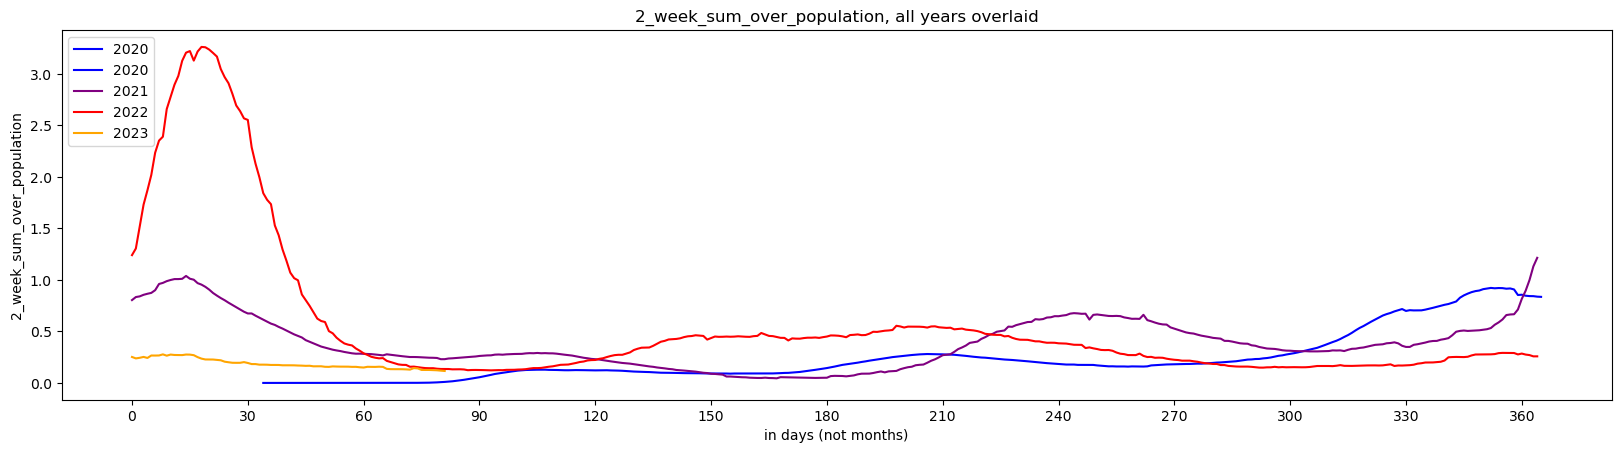

In [18]:
graph_year_overlap(US, '2_week_sum_over_population')

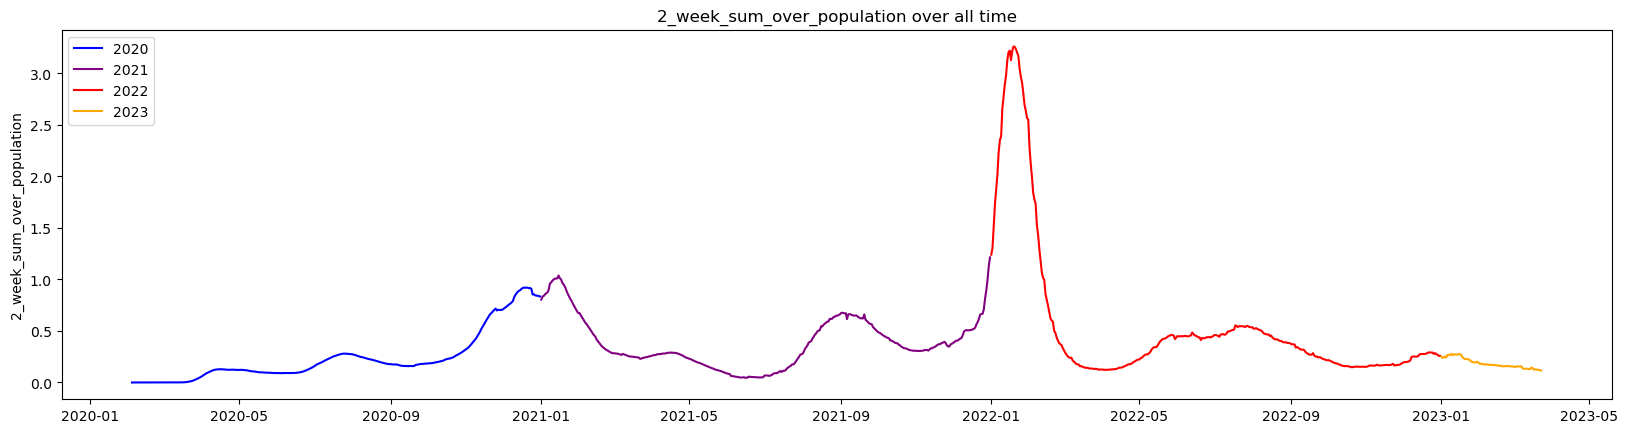

In [19]:
graph_over_time(US, '2_week_sum_over_population')

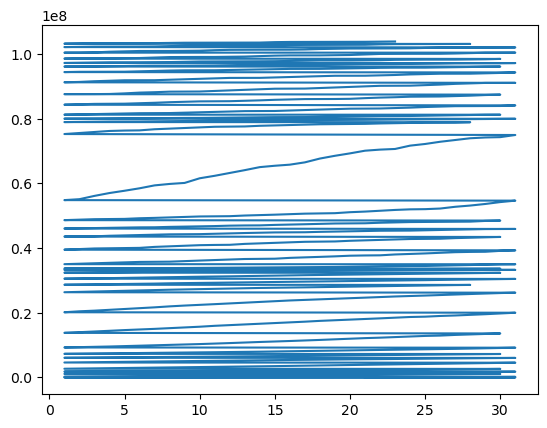

In [20]:
plt.plot(USdf.date.dt.day, USdf.cases)

Index(['date', 'state', 'fips', 'cases', 'deaths'], dtype='object')


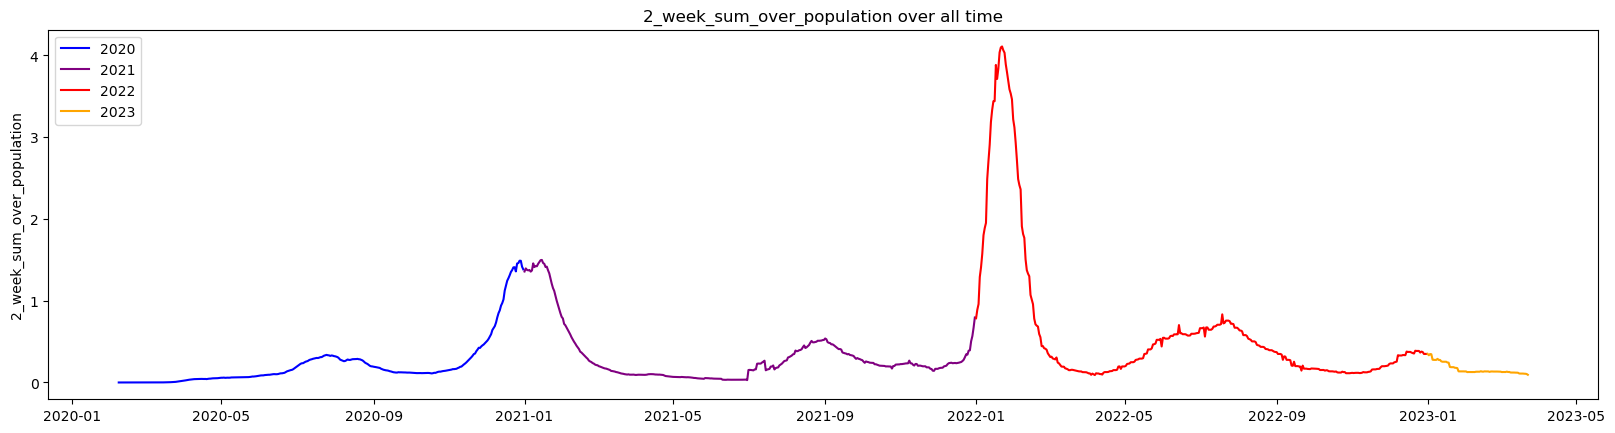

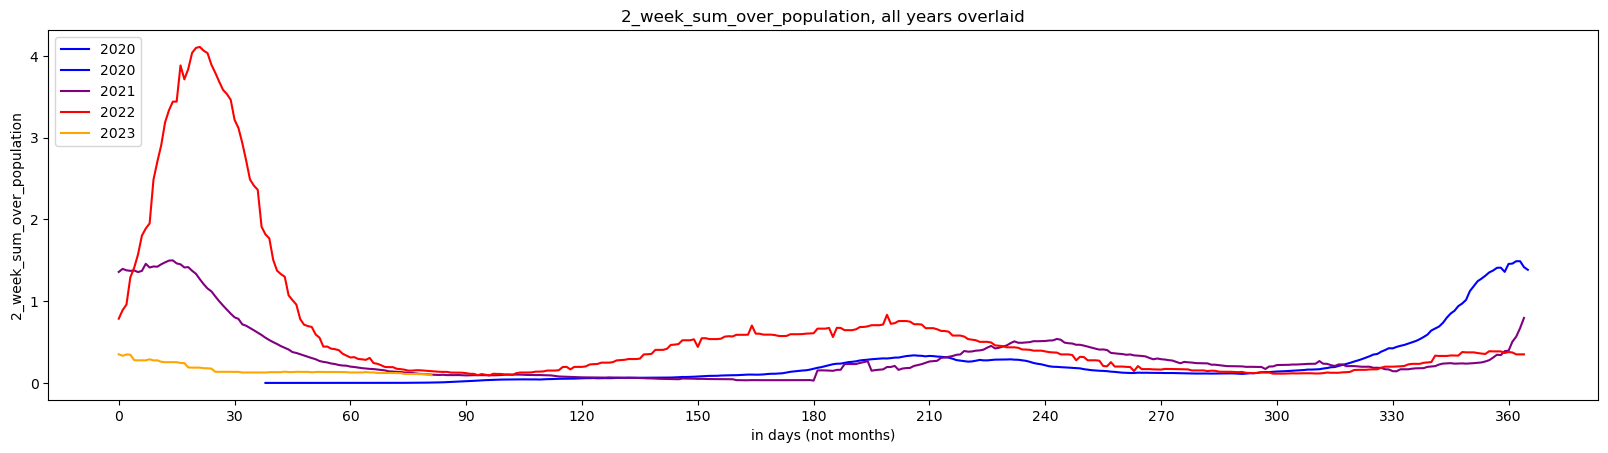

In [21]:
CA = transform_data(country='USA', state='California')
CA.tail(20)
graph_over_time(CA, '2_week_sum_over_population')
graph_year_overlap(CA, '2_week_sum_over_population')

In [22]:
WV = transform_data(country='USA', state='West Virginia')
Kanawha = transform_data(country='USA', state='West Virginia', county= 'Kanawha')
IL = transform_data(country='USA', state='Illinois')
Cook = transform_data(country='USA', state='Illinois', county= 'Cook')


Index(['date', 'state', 'fips', 'cases', 'deaths'], dtype='object')
Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')
Index(['date', 'state', 'fips', 'cases', 'deaths'], dtype='object')
Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


In [23]:
Alameda = transform_data(country='USA', state='California', county= 'Alameda')

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


In [27]:
WV.head(30)

,date,state,fips,cases,deaths,new_cases,7_day_average,2_week_sum,2_week_sum_over_population,case_totals_over_population
0,2020-03-17,West Virginia,54,1,0,NaN,NaN,NaN,NaN,0.000056
1,2020-03-18,West Virginia,54,2,0,1.0,NaN,NaN,NaN,0.000112
2,2020-03-19,West Virginia,54,5,0,3.0,NaN,NaN,NaN,0.000279
3,2020-03-20,West Virginia,54,8,0,3.0,NaN,NaN,NaN,0.000447
4,2020-03-21,West Virginia,54,12,0,4.0,NaN,NaN,NaN,0.000670
5,2020-03-22,West Virginia,54,16,0,4.0,NaN,NaN,NaN,0.000894
6,2020-03-23,West Virginia,54,16,0,0.0,NaN,NaN,NaN,0.000894
7,2020-03-24,West Virginia,54,39,0,23.0,5.428571,NaN,NaN,0.002179
8,2020-03-25,West Virginia,54,51,0,12.0,7.000000,NaN,NaN,0.002849
9,2020-03-26,West Virginia,54,76,0,25.0,10.142857,NaN,NaN,0.004246


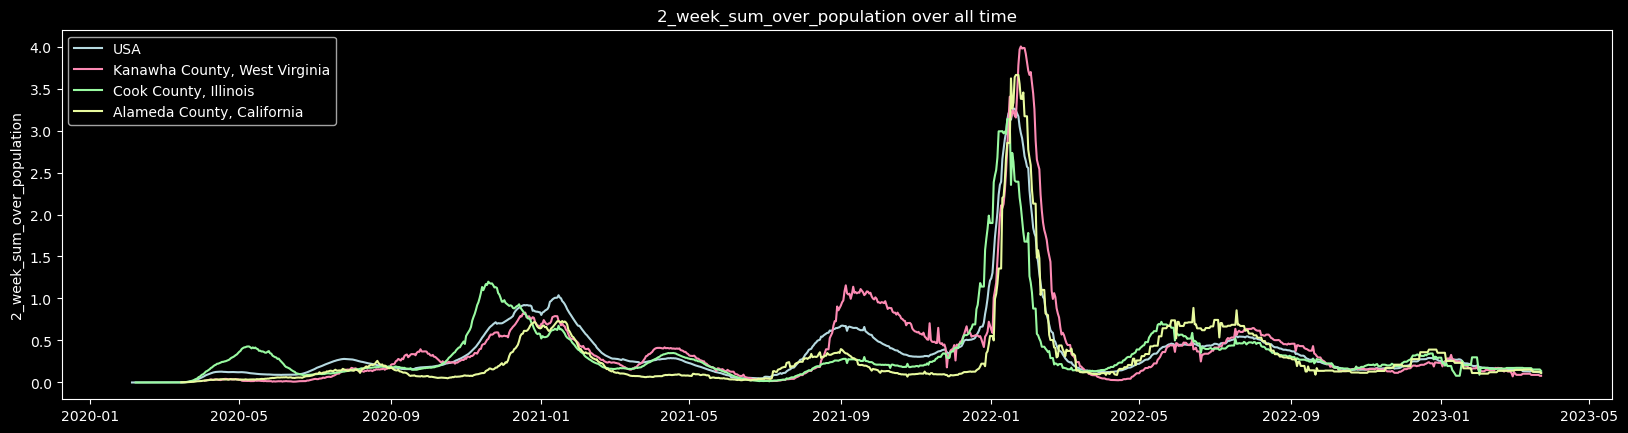

In [25]:
regional_comparison([US,Kanawha,Cook,Alameda], '2_week_sum_over_population')

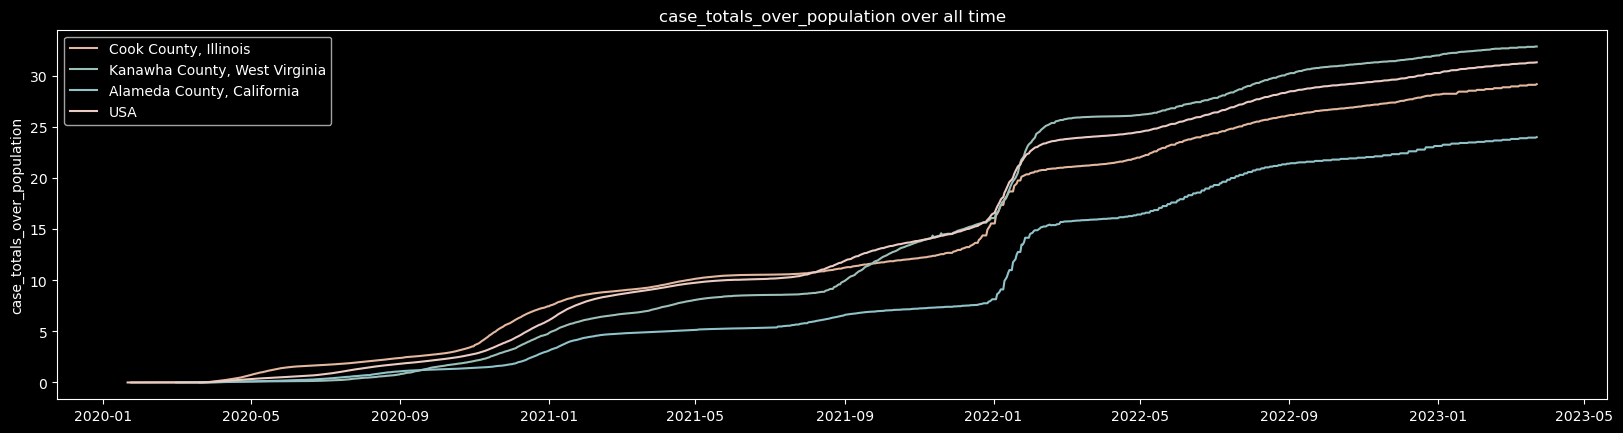

In [26]:
regional_comparison([Cook,Kanawha,Alameda,US], 'case_totals_over_population')

In [ ]:
NYNY = transform_data(country='USA', state='New York', county='New York City')


Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


TypeError: unsupported operand type(s) for -: 'str' and 'datetime.datetime'

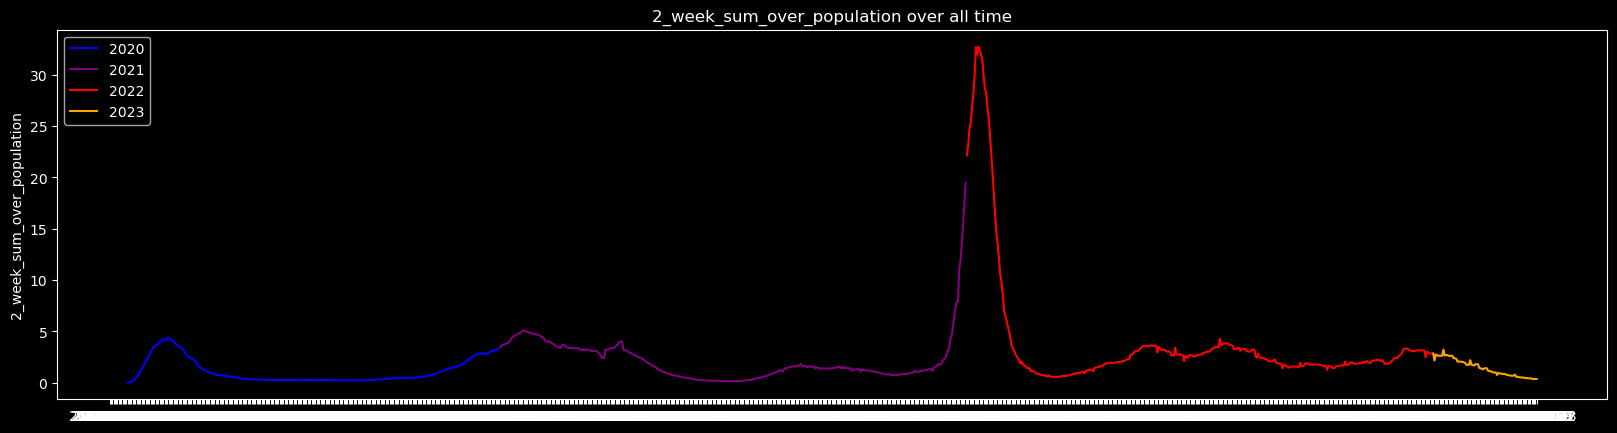

In [ ]:
graph_over_time(NYNY, '2_week_sum_over_population')
graph_year_overlap(NYNY, '2_week_sum_over_population')

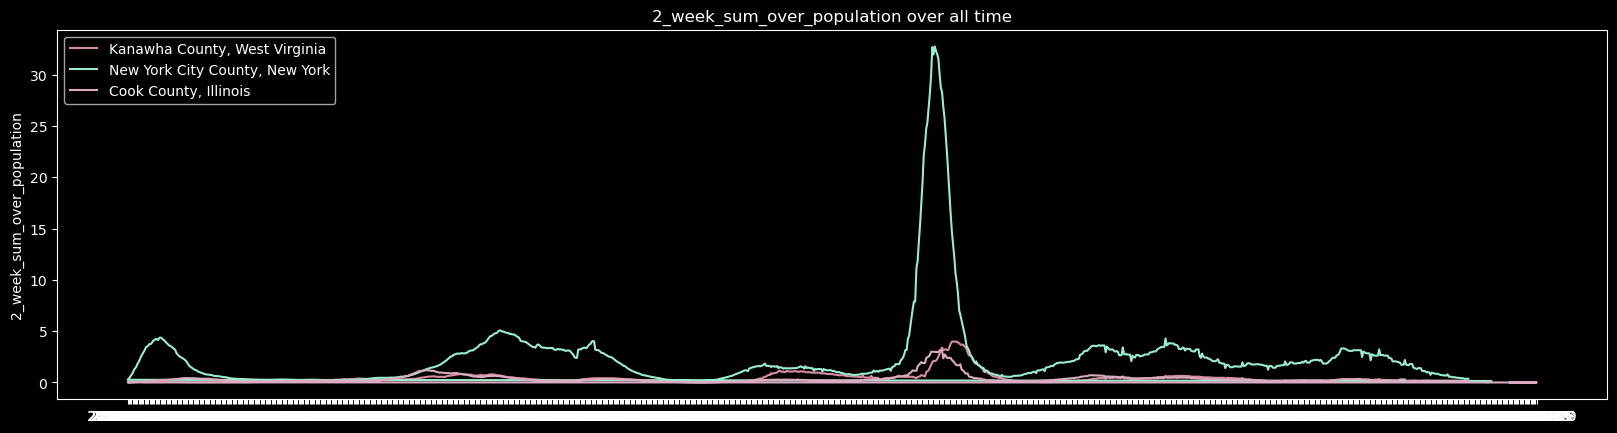

In [ ]:
regional_comparison([Kanawha,NYNY, Cook], '2_week_sum_over_population')

In [ ]:
NYNY.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fips,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deaths,1118.0,32526.921288,9976.292456,0.000000,24350.750000,33972.500000,40630.750000,45155.000000
7_day_average,1111.0,2926.628520,5028.053311,1.857143,768.142857,1918.285714,3483.428571,40525.571429
2_week_sum,1104.0,41213.439312,68219.020697,329.000000,11536.000000,27214.500000,49041.000000,554971.000000
2_week_sum_over_population,1104.0,2.432546,4.026500,0.019419,0.680891,1.606285,2.894553,32.756126


In [ ]:
# NYNY.loc[NYNY['2_week_sum_over_population'].idxmax()]

NYNY[NYNY.date == '2022-01-10 00:00:00']

,date,county,state,fips,cases,deaths,new_cases,7_day_average,2_week_sum,2_week_sum_over_population,case_totals_over_population


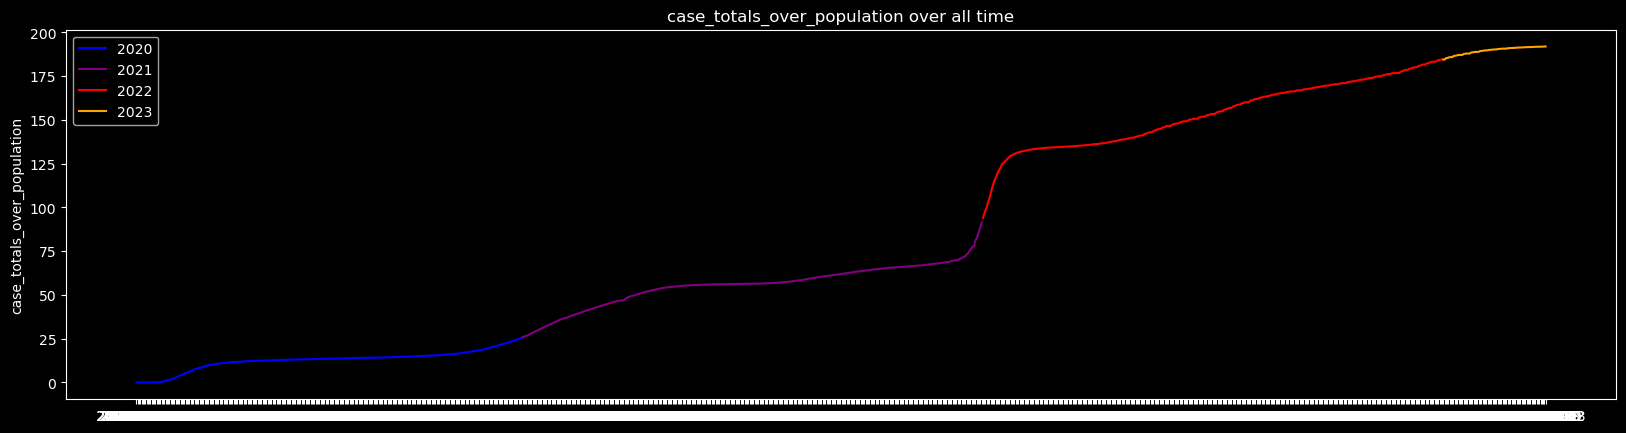

In [ ]:
graph_over_time(NYNY, 'case_totals_over_population')

In [ ]:
missing_regions = all_counties_df.state[~all_counties_df.state.isin(census_data.STNAME.unique())]
missing_regions.unique()



array(['Puerto Rico', 'Virgin Islands', 'Guam',
       'Northern Mariana Islands', 'American Samoa'], dtype=object)

In [ ]:
MI= all_counties_df.query('state == "Northern Mariana Islands"')

MI.county.unique()

array(['Unknown', 'Saipan', 'Tinian', 'Rota'], dtype=object)

In [ ]:
GUAM= all_counties_df.query('state == "Guam"')
GUAM.county.unique()

array(['Unknown'], dtype=object)

In [ ]:
SAMOA = all_counties_df.query('state == "American Samoa"')
SAMOA.county.unique()

array(['Unknown'], dtype=object)

In [ ]:
VI = all_counties_df.query('state == "Virgin Islands"')

VI.county.unique()

array(['Unknown', 'St. Croix', 'St. John', 'St. Thomas'], dtype=object)

In [ ]:
PR= all_counties_df.query('state == "Puerto Rico"')

PR.county.unique()

array(['Unknown', 'Adjuntas', 'Aguada', 'Aguadilla', 'Aguas Buenas',
       'Aibonito', 'Anasco', 'Arecibo', 'Arroyo', 'Barceloneta',
       'Barranquitas', 'Bayamon', 'Cabo Rojo', 'Caguas', 'Camuy',
       'Canovanas', 'Carolina', 'Catano', 'Cayey', 'Ceiba', 'Ciales',
       'Cidra', 'Coamo', 'Comerio', 'Corozal', 'Dorado', 'Fajardo',
       'Florida', 'Guanica', 'Guayama', 'Guayanilla', 'Guaynabo',
       'Gurabo', 'Hatillo', 'Hormigueros', 'Humacao', 'Isabela', 'Jayuya',
       'Juana Diaz', 'Juncos', 'Lajas', 'Lares', 'Las Marias',
       'Las Piedras', 'Loiza', 'Luquillo', 'Manati', 'Maunabo',
       'Mayaguez', 'Moca', 'Morovis', 'Naguabo', 'Naranjito', 'Orocovis',
       'Patillas', 'Penuelas', 'Ponce', 'Quebradillas', 'Rincon',
       'Rio Grande', 'Sabana Grande', 'Salinas', 'San German', 'San Juan',
       'San Lorenzo', 'San Sebastian', 'Santa Isabel', 'Toa Alta',
       'Toa Baja', 'Trujillo Alto', 'Utuado', 'Vega Alta', 'Vega Baja',
       'Villalba', 'Yabucoa', 'Yauco', '

In [ ]:
census_data.STNAME.unique()

# need vals for PR, Guam, VI, Mariana, Samoa

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
all_counties_df.date.max()

'2023-03-23'

In [ ]:
graph_year_overlap(Cook, '2_week_sum_over_population')

TypeError: unsupported operand type(s) for -: 'str' and 'datetime.datetime'

In [ ]:
Kanawha.date.dtype

dtype('O')

In [ ]:
df2020 = Kanawha.query('date.dt.year == 2020').reset_index()
df2021 = Kanawha.query('date.dt.year == 2021').reset_index()

plt.plot(df2020.date, df2020['2_week_sum_over_population'])
plt.plot(df2021.date[df2021.date - (365 * pd.offsets.Day)],df2021['2_week_sum_over_population'])

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# getit = pop_data.at[pop_data[pop_data.CTYNAME == 'Kanawha County'].index,'ESTIMATESBASE2020']
# getit

In [ ]:
herm = pop_data.ESTIMATESBASE2020.loc[pop_data.CTYNAME == 'Kanawha County']
herm

3061    180745
Name: ESTIMATESBASE2020, dtype: int64

In [ ]:
pop_index = pop_data[pop_data.CTYNAME.str.contains('Kanawha County')].index
ack = pop_data.at[pop_index[0], 'ESTIMATESBASE2020']
type(ack)

numpy.int64

In [ ]:
print(census_data.columns)
print()
print(pop_data.columns)
print()
print(USdf.columns)
print()
print(statedf.columns)
print()
print(all_counties_df.columns)

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021',
       'NPOPCHG2020', 'NPOPCHG2021', 'BIRTHS2020', 'BIRTHS2021', 'DEATHS2020',
       'DEATHS2021', 'NATURALCHG2020', 'NATURALCHG2021',
       'INTERNATIONALMIG2020', 'INTERNATIONALMIG2021', 'DOMESTICMIG2020',
       'DOMESTICMIG2021', 'NETMIG2020', 'NETMIG2021', 'RESIDUAL2020',
       'RESIDUAL2021', 'GQESTIMATESBASE2020', 'GQESTIMATES2020',
       'GQESTIMATES2021', 'RBIRTH2021', 'RDEATH2021', 'RNATURALCHG2021',
       'RINTERNATIONALMIG2021', 'RDOMESTICMIG2021', 'RNETMIG2021'],
      dtype='object')

Index(['STNAME', 'CTYNAME', 'ESTIMATESBASE2020', 'POPESTIMATE2020',
       'POPESTIMATE2021'],
      dtype='object')

Index(['date', 'cases', 'deaths'], dtype='object')

Index(['date', 'state', 'fips', 'cases', 'deaths'], dtype='object')

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


KeyboardInterrupt: 

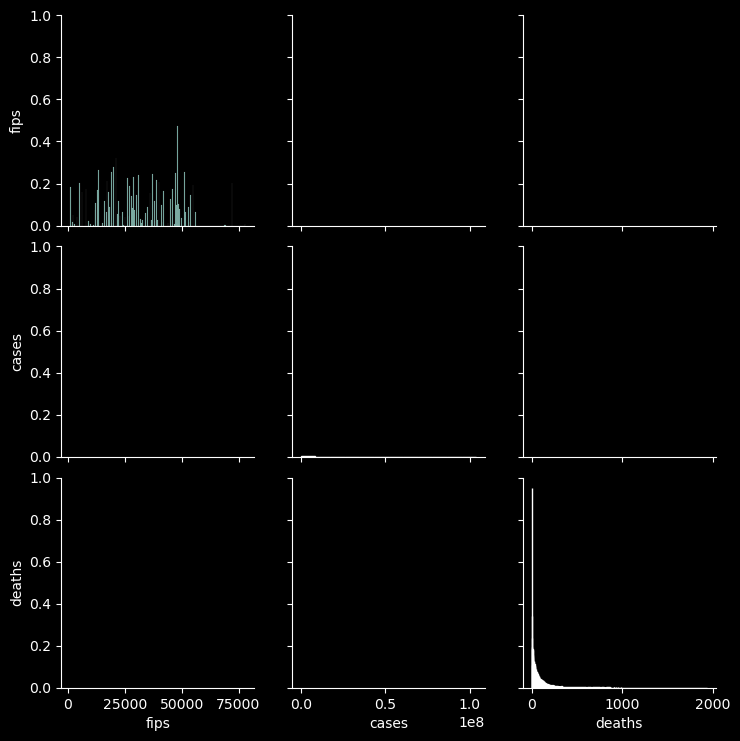

In [ ]:
sns.pairplot(all_counties_df)

<AxesSubplot: >

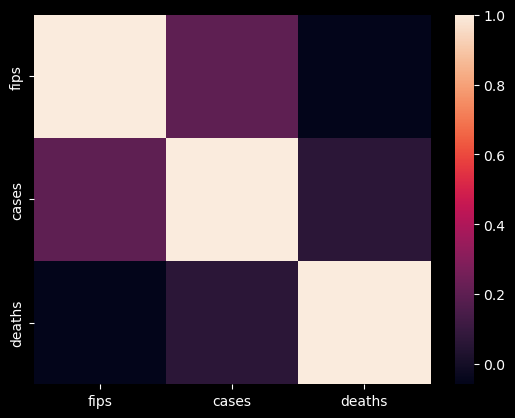

In [ ]:
sns.heatmap(all_counties_df[all_counties_df.columns[3:]].corr())

In [ ]:
Cook.i

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227711 entries, 0 to 1227710
Data columns (total 11 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   date                         47 non-null       datetime64[ns]
 1   county                       1227711 non-null  object        
 2   state                        1227711 non-null  object        
 3   fips                         1227711 non-null  float64       
 4   cases                        47 non-null       float64       
 5   deaths                       1227711 non-null  float64       
 6   new_cases                    46 non-null       float64       
 7   7_day_average                40 non-null       float64       
 8   2_week_sum                   33 non-null       float64       
 9   2_week_sum_over_population   33 non-null       float64       
 10  case_totals_over_population  47 non-null       float64       
dtypes: datetime

In [ ]:
all_counties_df.isnull().sum()

date      3524003
county          0
state           0
fips        35156
cases     3524003
deaths      82097
dtype: int64

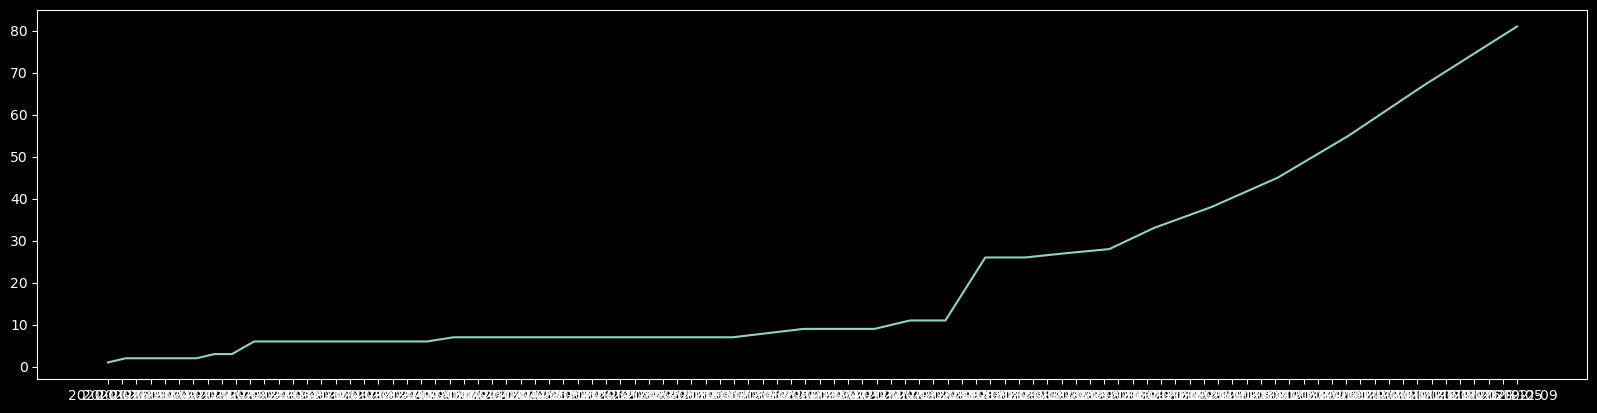

In [ ]:
byah = CA.query('date.dt.year == 2020')

f = plt.figure()
f.set_figwidth(20)

plt.plot(byah.date,byah.cases, label=2020)
plt.xticks(pd.date_range(start=byah.date.min(),end=byah.date.max(),periods=100))

plt.show()

In [ ]:
byah.date.max()

Timestamp('2020-12-09 00:00:00')

In [ ]:
print(USdf.info())
print()
print(US.info())
print()
print(statedf.info())
print()
print(WV.info())
print()
print(all_counties_df.info())
print()
print(Cook.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158 entries, 0 to 1157
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1158 non-null   object
 1   cases   1158 non-null   int64 
 2   deaths  1158 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 27.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1158 entries, 0 to 1157
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         1158 non-null   datetime64[ns]
 1   cases                        1158 non-null   int64         
 2   deaths                       1158 non-null   int64         
 3   new_cases                    1157 non-null   float64       
 4   7_day_average                1151 non-null   float64       
 5   2_week_sum                   1144 non-null   float64       
 6   2_week_sum_over_population

In [ ]:
tot = all_counties_df.date.count()

In [ ]:
tot

3525161

In [ ]:
all_counties_df.loc[(all_counties_df.fips.isnull()) & (all_counties_df.date == '2022-01-30')]

,date,county,state,fips,cases,deaths
2164523,2022-01-30,Unknown,Alaska,NaN,744,1.0
2164528,2022-01-30,Unknown,American Samoa,NaN,18,0.0
2164614,2022-01-30,Unknown,Arkansas,NaN,21954,0.0
2164749,2022-01-30,Unknown,Connecticut,NaN,2673,4.0
2164754,2022-01-30,Unknown,Delaware,NaN,886,0.0
2164819,2022-01-30,Unknown,Florida,NaN,22929,1192.0
2164968,2022-01-30,Unknown,Georgia,NaN,11696,14.0
2164984,2022-01-30,Unknown,Guam,NaN,32773,286.0
2164990,2022-01-30,Unknown,Hawaii,NaN,0,9.0
2165126,2022-01-30,Unknown,Illinois,NaN,0,1707.0


In [ ]:
all_counties_df.query('date == "2022-01-30" & state == "New Hampshire"')

,date,county,state,fips,cases,deaths
2166215,2022-01-30,Belknap,New Hampshire,33001.0,12045,158.0
2166216,2022-01-30,Carroll,New Hampshire,33003.0,8250,44.0
2166217,2022-01-30,Cheshire,New Hampshire,33005.0,12509,91.0
2166218,2022-01-30,Coos,New Hampshire,33007.0,6046,93.0
2166219,2022-01-30,Grafton,New Hampshire,33009.0,14507,53.0
2166220,2022-01-30,Hillsborough,New Hampshire,33011.0,88728,828.0
2166221,2022-01-30,Merrimack,New Hampshire,33013.0,28648,202.0
2166222,2022-01-30,Rockingham,New Hampshire,33015.0,60351,467.0
2166223,2022-01-30,Strafford,New Hampshire,33017.0,25055,185.0
2166224,2022-01-30,Sullivan,New Hampshire,33019.0,8008,60.0


In [ ]:
all_counties_df.query('date == "2022-01-30" & state == "New Hampshire"').cases.sum()

272492

In [ ]:
statedf.query('date == "2022-01-30" & state == "New Hampshire"') 

,date,state,fips,cases,deaths
38565,2022-01-30,New Hampshire,33,272492,2205


In [ ]:
census_data.query('STNAME == "New Hampshire"').CTYNAME

1794          New Hampshire
1795         Belknap County
1796         Carroll County
1797        Cheshire County
1798            Coos County
1799         Grafton County
1800    Hillsborough County
1801       Merrimack County
1802      Rockingham County
1803       Strafford County
1804        Sullivan County
Name: CTYNAME, dtype: object

In [ ]:
all_counties_df.query('date == "2022-01-30" & state == "New Hampshire"').county

2166215         Belknap
2166216         Carroll
2166217        Cheshire
2166218            Coos
2166219         Grafton
2166220    Hillsborough
2166221       Merrimack
2166222      Rockingham
2166223       Strafford
2166224        Sullivan
2166225         Unknown
Name: county, dtype: object

In [ ]:
csv_path = '/Users/chriskimmons/Desktop/viddy/'

WV.to_csv(csv_path + 'WV_cases.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      3194 non-null   object
 1   county     3194 non-null   object
 2   base20     3194 non-null   int64 
 3   pop_est20  3194 non-null   int64 
 4   pop_est21  3194 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 124.9+ KB


In [ ]:
def make_csv(df, filename):
    csv_path = '/Users/chriskimmons/Desktop/viddy/'
    df.to_csv(f'{csv_path}{filename}.csv')
    

In [ ]:
make_csv(Alameda,'Kanawha_cases')

In [ ]:
all_counties_df.to_parquet('/Users/chriskimmons/Desktop/viddy/all_counties_cleaned.parquet')

In [ ]:
state_pop = pop_data.query('state == county').drop_duplicates(keep='first').reset_index(drop=True)
state_pop

,state,county,base20,pop_est20,pop_est21
0,Alabama,Alabama,5024279,5024803,5039877
1,Alaska,Alaska,733391,732441,732673
2,Arizona,Arizona,7151502,7177986,7276316
3,Arkansas,Arkansas,3011524,3012232,3025891
4,California,California,39538223,39499738,39237836
5,Colorado,Colorado,5773714,5784308,5812069
6,Connecticut,Connecticut,3605944,3600260,3605597
7,Delaware,Delaware,989948,991886,1003384
8,District of Columbia,District of Columbia,689545,690093,670050
9,Florida,Florida,21538187,21569932,21781128


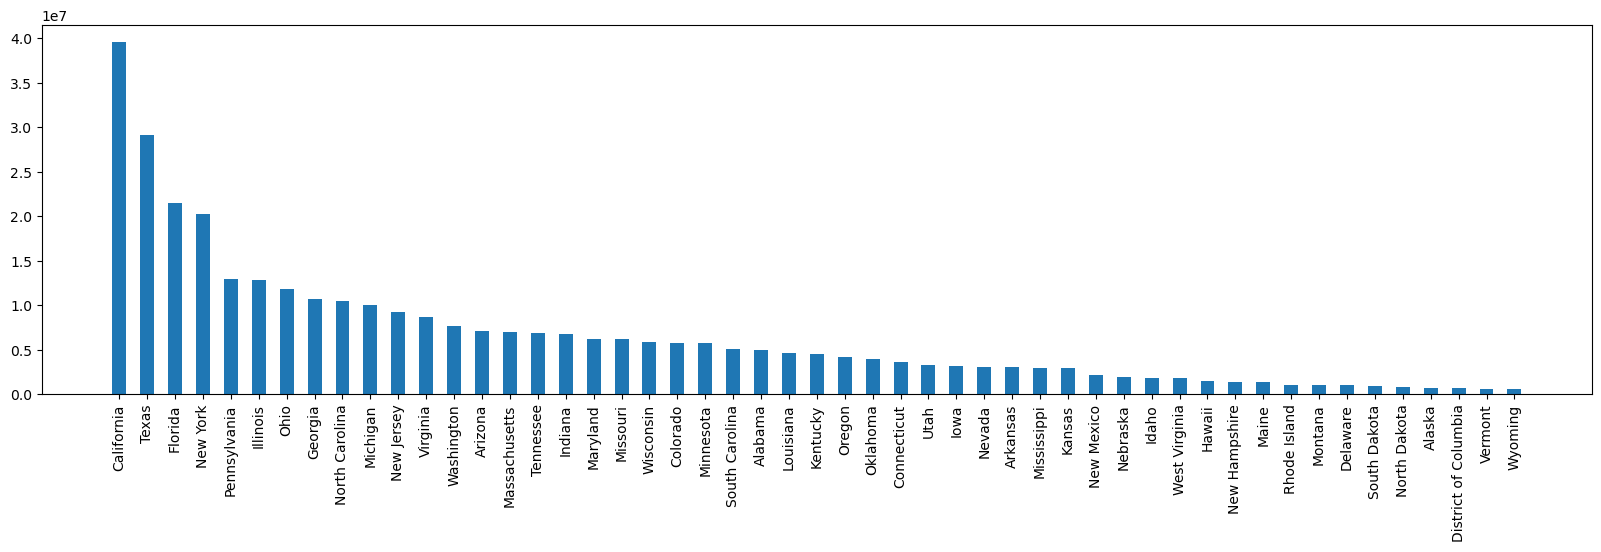

In [ ]:
sort_states = state_pop.sort_values(by='base20', ascending=False)
plt.figure().set_figwidth(20)
plt.bar(sort_states.state, sort_states.base20, width=0.5)
plt.xticks(sort_states.index,rotation=90)
plt.show()

In [33]:
pr_census = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/municipios/totals/PRM-EST2020.csv'
samoa_census = 'https://www2.census.gov/programs-surveys/decennial/2020/data/island-areas/american-samoa/population-and-housing-unit-counts/american-samoa-phc-table01.csv'
marianas_census = 'https://www2.census.gov/programs-surveys/decennial/2020/data/island-areas/commonwealth-of-the-northern-mariana-islands/population-and-housing-unit-counts/commonwealth-northern-mariana-islands-phc-table01.csv'
us_virgin_islands_census = 'https://www2.census.gov/programs-surveys/decennial/2020/data/island-areas/us-virgin-islands/population-and-housing-unit-counts/us-virgin-islands-phc-table01.csv'
guam_census = 'https://www2.census.gov/programs-surveys/decennial/2020/data/island-areas/guam/population-and-housing-unit-counts/guam-phc-table01.csv'

In [36]:
download_from_link(guam_census)

guam-phc-table01.csv


,ï»¿Population of Guam: 2010 and 2020,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,Population,NaN,Change \n(2020 less 2010),NaN
2,Geographic area,2010,2020,Number,Percent
3,NaN,,NaN,NaN,NaN
4,Guam,"159,358","153,836","-5,522",-3.5
5,NaN,NaN,NaN,NaN,NaN
6,Agana Heights municipality,"3,808","3,673",-135,-3.5
7,Agat municipality,"4,917","4,515",-402,-8.2
8,Asan municipality,"2,137","2,011",-126,-5.9
9,Barrigada municipality,"8,875","7,956",-919,-10.4
